In [1]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir
import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": 'serif'
})

try:
    os.mkdir('./ricker')
except: print('Folder exists')
try:
    os.mkdir('./ricker/gaussian')
except: print('Folder exists')
try:
    os.mkdir('./ricker/lowess')
except: print('Folder exists')
try:
    os.mkdir('./ricker/no_det')
except: print('Folder exists')

import matplotlib
from matplotlib.colors import ListedColormap, BoundaryNorm


Folder exists
Folder exists
Folder exists
Folder exists


In [2]:
from ewstools.models import simulate_ricker
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
trans=880
nruns=10
cmap = matplotlib.cm.get_cmap('plasma')
rw=0.2
for jrun in range(nruns):
    series = simulate_ricker(tmax=1000, F=[0,2.7])
    t=np.arange(0,len(series),1)
    ind_f=t
    ts = ews.TimeSeries(data=series, transition=trans)
    data=ts.state['state'].values
    ts.compute_var(rolling_window=rw)
    ts.compute_auto(lag=1, rolling_window=rw)
    ts.compute_auto(lag=2, rolling_window=rw)
    ts.compute_skew(rolling_window=rw)
    ts.compute_kurt(rolling_window=rw)
    ts.compute_ktau()
    #ewswin=varwin
    ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
    #smooth=ts.state['smoothing'].values
    ac1=ts.ews[ac_labels[0]].values
    ac2=ts.ews[ac_labels[1]].values
    var_ews=ts.ews['variance'].values
    sk_ews=ts.ews['skew'].values
    ku_ews=ts.ews['kurtosis'].values
    RTWc=np.nan*np.ones(len(ac1))
    Hg=np.nan*np.ones(len(ac1))
    Mr=np.nan*np.ones(len(ac1))
    var_mine=np.nan*np.ones(len(ac1))

    tidx = t[~np.isnan(ac1)]
    pnorm=(tidx-np.min(tidx))/np.max(tidx-np.min(tidx))
    np.sort(pnorm)
    norm = BoundaryNorm(np.sort(tidx[::4]), cmap.N)
    
    RTWc=[metrics.RTW_c(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    rtw=np.max((np.real(RTWc),np.imag(RTWc)),axis=0)
    Hg=[metrics.Hogg2(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    Mr=[metrics.Moors(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    var_mine=[np.var(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 

    fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
    plt.subplots_adjust(hspace=0.05)
    axs=ax[0,0]
    tau, p_value = st.kendalltau(rtw, tidx)
    axs.plot(tidx,rtw,color=CB_color_cycle[0],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.plot(tidx-tidx[0]/2,rtw,color=CB_color_cycle[0],linewidth=2,alpha=0.7)
    axs.set_title('No detrending')
    axs.set_ylabel('RTW')
    axs=ax[1,0]
    tau, p_value = st.kendalltau(Mr, tidx)
    axs.plot(tidx,Mr,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.plot(tidx-tidx[0]/2,Mr,color=CB_color_cycle[0],linewidth=2,alpha=0.4)
    axs.set_ylabel('Moors')
    axs=ax[2,0]
    tau, p_value = st.kendalltau(Hg, tidx)
    axs.plot(tidx,Hg,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.plot(tidx-tidx[0]/2,Hg,color=CB_color_cycle[0],linewidth=2,alpha=0.4)
    axs.set_ylabel('Hogg')
    axs=ax[3,0]
    axs.plot(ind_f,ku_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['kurtosis']))
    axs.set_ylabel('Kurtosis')
    axs=ax[4,0]
    axs.plot(ind_f,sk_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['skew']))
    axs.set_ylabel('Skewness')
    axs=ax[0,1]
    tau, p_value = st.kendalltau(ac1[tidx], ac2[tidx])
    axs.set_title(r'$k^{1,2}_{\tau}=%.2f$' %(tau))
    axs.plot(ind_f,ac1,color=CB_color_cycle[2],linewidth=2,label=r'$k^1_{\tau}=%.2f$' %(ts.ktau[ac_labels[0]]))
    axs.plot(ind_f,ac2,color=CB_color_cycle[4],linewidth=2,label=r'$k^2_{\tau}=%.2f$' %(ts.ktau[ac_labels[1]]))
    axs.set_ylabel('Lag_{1,2}')
    axs=ax[1,1]
    axs.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
    #axs.plot(ind,var_mine)
    axs.set_ylabel('Variance ')
    axs=ax[2,1]
    tau, p_value = st.kendalltau(-(ac1[tidx]-1), tidx)
    axs.plot(ind_f,-(ac1-1),color=CB_color_cycle[2],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('M')
    axs=ax[3,1]
    tau, p_value = st.kendalltau(var_ews[tidx]/(ac1[tidx]-1), tidx)
    axs.plot(ind_f,var_ews/(ac1-1),color=CB_color_cycle[3],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Var/(Lag-1)')
    axs=ax[5,0]
    tau, p_value = st.kendalltau(np.abs(RTWc), tidx)
    axs.plot(tidx,np.abs(RTWc),linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('|RTWc|')
    axs=ax[5,1]
    axs.plot(ind_f,ts.state['state'].values,'k',linewidth=2)
    axs.set_ylabel('Trayectory')
    for axs in ax.ravel():   
        ylim=axs.get_ylim()
        axs.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.5)
        axs.set_xlim([0,len(series)])
        axs.legend()
    fig.savefig(str('./ricker/no_det/%.3i' %(jrun))+'no_detrend.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
   
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    plt.scatter(ac1[tidx],ac2[tidx],color=cmap(np.int64(255*pnorm)))
    #cbar_ax = fig.add_axes([0.9, 0.05, 0.05, 0.9])
    cbar=plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='Time',ticks=np.sort(tidx[::80]))
    #cbar.set_label('Time', rotation=90,fontsize=16,labelpad=3)
    ax.set_facecolor((170/255,170/255 ,170/255,0.8 ))
    ax.set_ylabel('ARC2')
    ax.set_xlabel('ARC1')
    fig.savefig(str('./ricker/no_det/%.3i' %(jrun))+'ac12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    plt.plot(tidx,ac1[tidx]/ac2[tidx])
    plt.plot(tidx,0*tidx,'-k')
    ax.set_ylim([-20,20])
    ax.set_ylabel('ARC1/ARC2')
    ax.set_xlabel('Time')
    fig.savefig(str('./ricker/no_det/%.3i' %(jrun))+'act12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    #############################################################################

    ts = ews.TimeSeries(data=series, transition=trans)
    ts.detrend(method='Lowess', span=0.3)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    ts.compute_var(rolling_window=rw)
    ts.compute_auto(lag=1, rolling_window=rw)
    ts.compute_auto(lag=2, rolling_window=rw)
    ts.compute_skew(rolling_window=rw)
    ts.compute_kurt(rolling_window=rw)
    ts.compute_ktau()
    #ewswin=varwin
    ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
    #smooth=ts.state['smoothing'].values
    ac1=ts.ews[ac_labels[0]].values
    ac2=ts.ews[ac_labels[1]].values
    var_ews=ts.ews['variance'].values
    sk_ews=ts.ews['skew'].values
    ku_ews=ts.ews['kurtosis'].values
    RTWc=np.nan*np.ones(len(ac1))
    Hg=np.nan*np.ones(len(ac1))
    Mr=np.nan*np.ones(len(ac1))
    var_mine=np.nan*np.ones(len(ac1))

    tidx = t[~np.isnan(ac1)]
    
    RTWc=[metrics.RTW_c(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    rtw=np.max((np.real(RTWc),np.imag(RTWc)),axis=0)
    Hg=[metrics.Hogg2(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    Mr=[metrics.Moors(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    var_mine=[np.var(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 

    fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
    plt.subplots_adjust(hspace=0.05)
    axs=ax[0,0]
    tau, p_value = st.kendalltau(rtw, tidx)
    axs.plot(tidx,rtw,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_title('Lowess detrending')
    axs.set_ylabel('RTW')
    axs=ax[1,0]
    tau, p_value = st.kendalltau(Mr, tidx)
    axs.plot(tidx,Mr,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Moors')
    axs=ax[2,0]
    tau, p_value = st.kendalltau(Hg, tidx)
    axs.plot(tidx,Hg,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Hogg')
    axs=ax[3,0]
    axs.plot(ind_f,ku_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['kurtosis']))
    axs.set_ylabel('Kurtosis')
    axs=ax[4,0]
    axs.plot(ind_f,sk_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['skew']))
    axs.set_ylabel('Skewness')
    axs=ax[0,1]
    tau, p_value = st.kendalltau(ac1[tidx], ac2[tidx])
    axs.set_title(r'$k^{1,2}_{\tau}=%.2f$' %(tau))
    axs.plot(ind_f,ac1,color=CB_color_cycle[2],linewidth=2,label=r'$k^1_{\tau}=%.2f$' %(ts.ktau[ac_labels[0]]))
    axs.plot(ind_f,ac2,color=CB_color_cycle[4],linewidth=2,label=r'$k^2_{\tau}=%.2f$' %(ts.ktau[ac_labels[1]]))
    axs.set_ylabel('Lag_{1,2}')
    axs=ax[1,1]
    axs.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
    #axs.plot(ind,var_mine)
    axs.set_ylabel('Variance ')
    axs=ax[2,1]
    tau, p_value = st.kendalltau(-(ac1[tidx]-1), tidx)
    axs.plot(ind_f,-(ac1-1),color=CB_color_cycle[2],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('M')
    axs=ax[3,1]
    tau, p_value = st.kendalltau(var_ews[tidx]/(ac1[tidx]-1), tidx)
    axs.plot(ind_f,var_ews/(ac1-1),color=CB_color_cycle[3],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Var/(Lag-1)')
    axs=ax[5,0]
    tau, p_value = st.kendalltau(np.abs(RTWc), tidx)
    axs.plot(tidx,np.abs(RTWc),linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('|RTWc|')
    axs=ax[4,1]
    axs.plot(ind_f,residuals,'gray',linewidth=2)
    axs.set_ylabel('Residuals')
    axs=ax[5,1]
    axs.plot(ind_f,ts.state['state'].values,'k',linewidth=2)
    axs.set_ylabel('Trayectory')
    for axs in ax.ravel():   
        ylim=axs.get_ylim()
        axs.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.5)
        axs.set_xlim([0,len(series)])
        axs.legend()      
    fig.savefig(str('./ricker/lowess/%.3i' %(jrun))+'lowess.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    

   
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    plt.scatter(ac1[tidx],ac2[tidx],color=cmap(np.int64(255*pnorm)))
    #cbar_ax = fig.add_axes([0.9, 0.05, 0.05, 0.9])
    cbar=plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='Time',ticks=np.sort(tidx[::80]))
    #cbar.set_label('Time', rotation=90,fontsize=16,labelpad=3)
    ax.set_facecolor((170/255,170/255 ,170/255,0.8 ))
    ax.set_ylabel('ARC2')
    ax.set_xlabel('ARC1')
    fig.savefig(str('./ricker/lowess/%.3i' %(jrun))+'ac12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    plt.plot(tidx,ac1[tidx]/ac2[tidx])
    plt.plot(tidx,0*tidx,'-k')
    ax.set_ylim([-20,20])
    ax.set_ylabel('ARC1/ARC2')
    ax.set_xlabel('Time')
    fig.savefig(str('./ricker/lowess/%.3i' %(jrun))+'act12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

    ############################################################################


    ts = ews.TimeSeries(data=series, transition=trans)
    ts.detrend(method='Gaussian',bandwidth=0.1, span=0.3)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    ts.compute_var(rolling_window=rw)
    ts.compute_auto(lag=1, rolling_window=rw)
    ts.compute_auto(lag=2, rolling_window=rw)
    ts.compute_skew(rolling_window=rw)
    ts.compute_kurt(rolling_window=rw)
    ts.compute_ktau()
    #ewswin=varwin
    ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
    ac1=ts.ews[ac_labels[0]].values
    ac2=ts.ews[ac_labels[1]].values
    var_ews=ts.ews['variance'].values
    sk_ews=ts.ews['skew'].values
    ku_ews=ts.ews['kurtosis'].values
    RTWc=np.nan*np.ones(len(ac1))
    Hg=np.nan*np.ones(len(ac1))
    Mr=np.nan*np.ones(len(ac1))
    var_mine=np.nan*np.ones(len(ac1))

    tidx = t[~np.isnan(ac1)]
    
    RTWc=[metrics.RTW_c(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    rtw=np.max((np.real(RTWc),np.imag(RTWc)),axis=0)
    Hg=[metrics.Hogg2(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    Mr=[metrics.Moors(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
    var_mine=[np.var(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 

    fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
    plt.subplots_adjust(hspace=0.05)
    axs=ax[0,0]
    tau, p_value = st.kendalltau(rtw, tidx)
    axs.plot(tidx,rtw,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_title('Gaussian detrending')
    axs.set_ylabel('RTW')
    axs=ax[1,0]
    tau, p_value = st.kendalltau(Mr, tidx)
    axs.plot(tidx,Mr,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Moors')
    axs=ax[2,0]
    tau, p_value = st.kendalltau(Hg, tidx)
    axs.plot(tidx,Hg,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Hogg')
    axs=ax[3,0]
    axs.plot(ind_f,ku_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['kurtosis']))
    axs.set_ylabel('Kurtosis')
    axs=ax[4,0]
    axs.plot(ind_f,sk_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['skew']))
    axs.set_ylabel('Skewness')
    axs=ax[0,1]
    tau, p_value = st.kendalltau(ac1[tidx], ac2[tidx])
    axs.set_title(r'$k^{1,2}_{\tau}=%.2f$' %(tau))
    axs.plot(ind_f,ac1,color=CB_color_cycle[2],linewidth=2,label=r'$k^1_{\tau}=%.2f$' %(ts.ktau[ac_labels[0]]))
    axs.plot(ind_f,ac2,color=CB_color_cycle[4],linewidth=2,label=r'$k^2_{\tau}=%.2f$' %(ts.ktau[ac_labels[1]]))
    axs.set_ylabel('Lag_{1,2}')
    axs=ax[1,1]
    axs.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
    #axs.plot(ind,var_mine)
    axs.set_ylabel('Variance ')
    axs=ax[2,1]
    tau, p_value = st.kendalltau(-(ac1[tidx]-1), tidx)
    axs.plot(ind_f,-(ac1-1),color=CB_color_cycle[2],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('M')
    axs=ax[3,1]
    tau, p_value = st.kendalltau(var_ews[tidx]/(ac1[tidx]-1), tidx)
    axs.plot(ind_f,var_ews/(ac1-1),color=CB_color_cycle[3],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('Var/(Lag-1)')
    axs=ax[5,0]
    tau, p_value = st.kendalltau(np.abs(RTWc), tidx)
    axs.plot(tidx,np.abs(RTWc),linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
    axs.set_ylabel('|RTWc|')
    axs=ax[5,1]
    axs.plot(ind_f,ts.state['state'].values,'k',linewidth=2)
    axs.set_ylabel('Trayectory')
    axs=ax[4,1]
    axs.plot(ind_f,residuals,'gray',linewidth=2)
    axs.set_ylabel('Residuals')
    for axs in ax.ravel():   
        ylim=axs.get_ylim()
        axs.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.5)
        axs.set_xlim([0,len(series)])
        axs.legend()
         
    fig.savefig(str('./ricker/gaussian/%.3i'%(jrun))+'gaussian.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    plt.scatter(ac1[tidx],ac2[tidx],color=cmap(np.int64(255*pnorm)))
    #cbar_ax = fig.add_axes([0.9, 0.05, 0.05, 0.9])
    cbar=plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='Time',ticks=np.sort(tidx[::80]))
    #cbar.set_label('Time', rotation=90,fontsize=16,labelpad=3)
    ax.set_facecolor((170/255,170/255 ,170/255,0.8 ))
    ax.set_ylabel('ARC2')
    ax.set_xlabel('ARC1')
    fig.savefig(str('./ricker/gaussian/%.3i' %(jrun))+'ac12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
    ax.plot(tidx,ac1[tidx]/ac2[tidx])
    ax.plot(tidx,0*tidx,'-k')
    ax.set_ylim([-20,20])
    ax.set_ylabel('ARC1/ARC2')
    ax.set_xlabel('Time')
    fig.savefig(str('./ricker/gaussian/%.3i' %(jrun))+'act12.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

In [4]:
len(Hg)

706

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


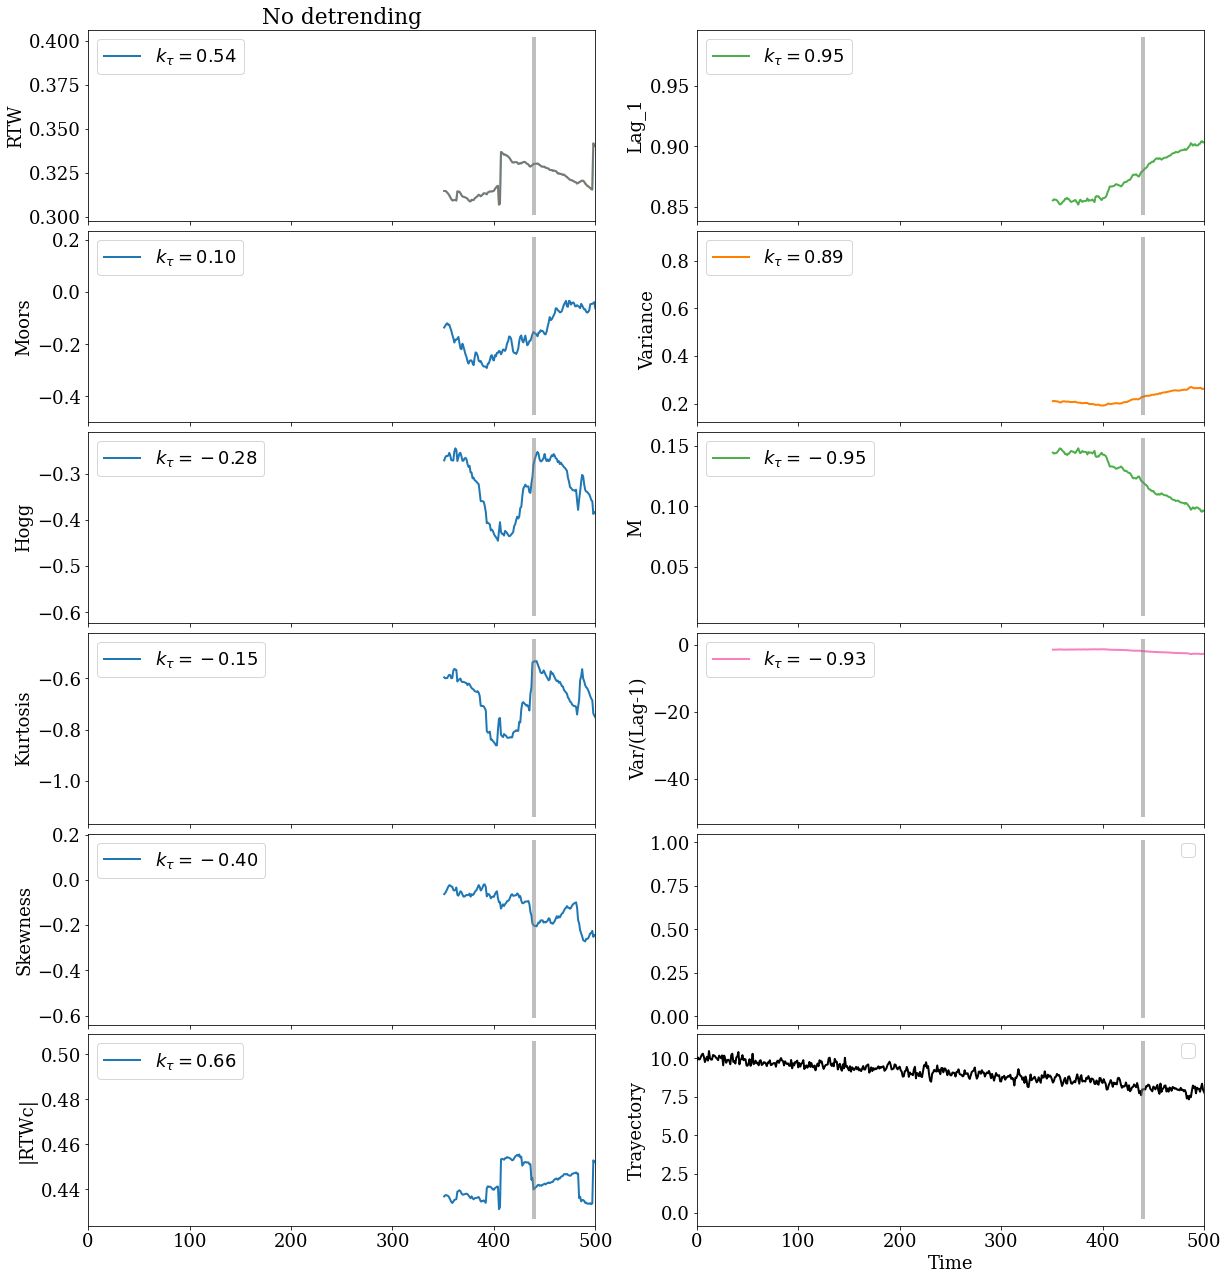

In [8]:
ts = ews.TimeSeries(data=series, transition=trans)
rw=0.4
ts.compute_var(rolling_window=rw)
ts.compute_auto(lag=1, rolling_window=rw)
ts.compute_auto(lag=2, rolling_window=rw)
ts.compute_skew(rolling_window=rw)
ts.compute_kurt(rolling_window=rw)
ts.compute_ktau()
#ewswin=varwin
ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
#smooth=ts.state['smoothing'].values
ac1=ts.ews[ac_labels[0]].values
var_ews=ts.ews['variance'].values
sk_ews=ts.ews['skew'].values
ku_ews=ts.ews['kurtosis'].values
RTWc=np.nan*np.ones(len(ac1))
Hg=np.nan*np.ones(len(ac1))
Mr=np.nan*np.ones(len(ac1))
var_mine=np.nan*np.ones(len(ac1))


t=np.arange(0,len(ac1),1)
tidx = t[~np.isnan(ac1)]

#residuals=ts.state['residuals'].values
data=ts.state['state'].values
sl_win=int(rw*len(data))-1

RTWc=[metrics.RTW_c(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
rtw=np.max((np.real(RTWc),np.imag(RTWc)),axis=0)
Hg=[metrics.Hogg2(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
Mr=[metrics.Moors(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 
var_mine=[np.var(data[j:tidx[j]]) for j  in  range(len(tidx)) ] 


fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
plt.subplots_adjust(hspace=0.05)
axs=ax[0,0]
tau, p_value = st.kendalltau(rtw, tidx)
axs.plot(tidx,rtw,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.plot(tidx-rw/2,rtw,linewidth=2,alpha=0.4)
axs.set_title('No detrending')
axs.set_ylabel('RTW')
axs=ax[1,0]
tau, p_value = st.kendalltau(Mr, tidx)
axs.plot(tidx,Mr,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.set_ylabel('Moors')
axs=ax[2,0]
tau, p_value = st.kendalltau(Hg, tidx)
axs.plot(tidx,Hg,linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.set_ylabel('Hogg')
axs=ax[3,0]
axs.plot(ind_f,ku_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['kurtosis']))
axs.set_ylabel('Kurtosis')
axs=ax[4,0]
axs.plot(ind_f,sk_ews,linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['skew']))
axs.set_ylabel('Skewness')
axs=ax[0,1]
axs.plot(ind_f,ac1,color=CB_color_cycle[2],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau[ac_labels[0]]))
axs.set_ylabel('Lag_1')
axs=ax[1,1]
axs.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
#axs.plot(ind,var_mine)
axs.set_ylabel('Variance ')
axs=ax[2,1]
tau, p_value = st.kendalltau(-(ac1[tidx]-1), tidx)
axs.plot(ind_f,-(ac1-1),color=CB_color_cycle[2],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.set_ylabel('M')
axs=ax[3,1]
tau, p_value = st.kendalltau(var_ews[tidx]/(ac1[tidx]-1), tidx)
axs.plot(ind_f,var_ews/(ac1-1),color=CB_color_cycle[3],linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.set_ylabel('Var/(Lag-1)')
axs=ax[5,0]
tau, p_value = st.kendalltau(np.abs(RTWc), tidx)
axs.plot(tidx,np.abs(RTWc),linewidth=2,label=r'$k_{\tau}=%.2f$' %(tau))
axs.set_ylabel('|RTWc|')
axs=ax[5,1]
axs.plot(ind_f,ts.state['state'].values,'k',linewidth=2)
axs.set_ylabel('Trayectory')
axs.set_xlabel('Time')
for axs in ax.ravel():   
    ylim=axs.get_ylim()
    axs.plot([440,440],ylim,'-',linewidth=4,color='gray',alpha=0.5)
    axs.set_xlim([0,500])
    axs.legend()



Text(0.5, 0, 'ARC1')

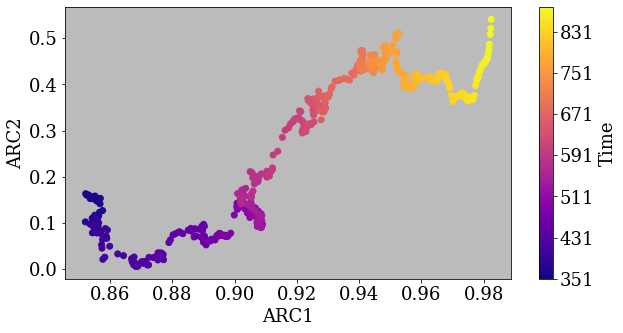

In [9]:


cmap = matplotlib.cm.get_cmap('plasma')
pnorm=(tidx-np.min(tidx))/np.max(tidx-np.min(tidx))
np.sort(pnorm)
norm = BoundaryNorm(np.sort(tidx[::4]), cmap.N)
fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
plt.scatter(ac1[tidx],ac2[tidx],color=cmap(np.int64(255*pnorm)))
#cbar_ax = fig.add_axes([0.9, 0.05, 0.05, 0.9])
cbar=plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='Time',ticks=np.sort(tidx[::80]))
#cbar.set_label('Time', rotation=90,fontsize=16,labelpad=3)
ax.set_facecolor((170/255,170/255 ,170/255,0.8 ))
ax.set_ylabel('ARC2')
ax.set_xlabel('ARC1')
#plt.close(fig)

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col',figsize=(10,5))
ax.plot(tidx,ac1[tidx]/ac2[tidx])
ax.plot(tidx,0*tidx,'-k')
ax.set_ylim([-20,20])
ax.set_ylabel('ARC1/ARC2')
ax.set_xlabel('Time')